# 2 - Labelling view datasets with pretrained model

In this tutorial, we will work with a view dataset that we created in the previous tutorial, and label that with web-image trained models. Lots of the code in this notebook is just going to be boilerplate to use our pretrained models as label extractors, but the core idea is that we are taking a "view dataset", defined in the previous tutorial as a combination of RGB, depth, and confidence information, and convert that to point-wise dataset that contains the XYZ position of a point, a semantic encoding of the label of whatever is at that point, and a vision-language model (aka CLIP) embedding of whatever object is at that point.

Conceretely, the dataset we create will have a `__getitem__` method that returns a dictionary with the following keys:
```python
{
    "xyz": torch.Tensor, # (3,) tensor of XYZ position of point
    "rgb": torch.Tensor, # (3,) tensor of RGB color of point
    "label": torch.Tensor, # (1,) tensor ID of semantic label of point
    "instance": torch.Tensor, # (1,) tensor ID of instance label of point, if exists, else -1
    "img_idx": torch.Tensor, # (1,) tensor ID of image that point was sampled from, or the bounding box that this point is a part of.
    "distance": torch.Tensor, # (1,) tensor of distance from point to camera
    "clip_vector": torch.Tensor, # (512,) or (768,), tensor of CLIP-text or Sentence-BERT embedding of point
    "clip_image_vector": torch.Tensor, # (512,) or (768,), tensor of CLIP-image embedding of point
    "semantic_weight": torch.Tensor, # (1,) tensor of weight of semantic label of point; generally the confidence of the semantic label coming from the detector.
}
```

Since this class uses a lot of boilerplate code, we are not reproducing it here, but you can find the code for our pretrained model based labeller in `dataloaders/real_dataset.py`

In [1]:
import sys
sys.path.append('..')

import torch
from dataloaders import R3DSemanticDataset, DeticDenseLabelledDataset, OWLViTLabelledDataset

# Load the dataset
# If you are following up after tutorial 1
# dataset = torch.load("../nyu_views.pth")
# Otherwise, create from scratch.
dataset = R3DSemanticDataset("../Kitchen2.r3d")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-28 20:25:42.079575: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/robot-lab/anaconda3/envs/cf/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu::/home/robot-lab/.mujoco/mujoco200/bin::/home/robot-lab/.mujoco/mjpro150/bin
2023-08-28 20:25:42.079623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Calculating global XYZs: 100%|████████████████████████████████████████████████████████| 880/880 [00:32<00:00, 27.14it/s]


In [ ]:
labelled_dataset = OWLViTLabelledDataset(
    dataset, 
    use_extra_classes=False, 
    exclude_gt_images=False,  
    subsample_prob=0.001, 
    visualize_results=True, 
    owl_threshold = 0.1,
    visualization_path="owl_labelled_results",
    sam_model_path_name="../sam_vit_h_4b8939.pth",
)

INFO - 2023-08-28 20:26:33,132 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO - 2023-08-28 20:26:34,847 - SentenceTransformer - Use pytorch device: cuda
Calculating OWL features:   0%|                                                                 | 0/880 [00:00<?, ?it/s]/home/robot-lab/.local/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
Calculating OWL features:  98%|█████████████████████████████████████████████████████▊ | 860/880 [10

In [ ]:
labelled_dataset = SAMLabelledDataset(
    dataset, 
    use_extra_classes=False, 
    exclude_gt_images=False, 
    use_lseg=False, 
    subsample_prob=0.01, 
    visualize_results=True, 
    detic_threshold=0.4,
    visualization_path="sam_labelled_results",
)

In [4]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import clip
import einops
import tqdm
from matplotlib import pyplot as plt

In [5]:
image_width, image_height = dataset.image_size 

In [5]:
clip_model, _ = clip.load('ViT-B/32', device='cuda')

In [22]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side = 16, pred_iou_thresh = 0.95)

In [38]:
for idx in range(len(masks)):
    masks[idx]['label'] = "chair"

  0%|                                                                                           | 0/757 [00:00<?, ?it/s]

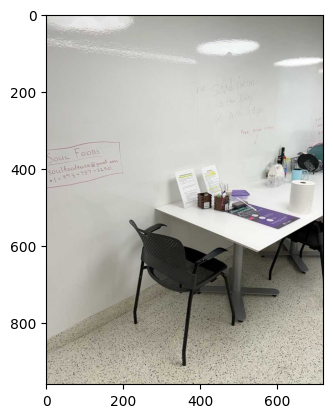

  0%|                                                                                           | 0/757 [00:00<?, ?it/s]


In [9]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=False)
for idx, data_dict in tqdm.tqdm(enumerate(dataloader), total=len(dataset)):
    rgb = einops.rearrange(data_dict["rgb"][..., :3], "b h w c -> b c h w")
    xyz = data_dict["xyz_position"]
    for image, coordinates in zip(rgb, xyz):
        #image[:, data_dict['conf'][0] != 2] = 0
        plt.imshow(image.permute(1, 2, 0))
        plt.show()
    break

In [10]:
resize = transforms.Resize((224, 224))

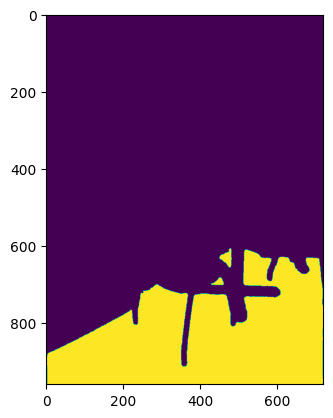

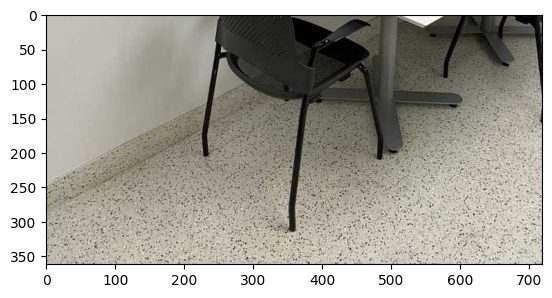

torch.Size([512])


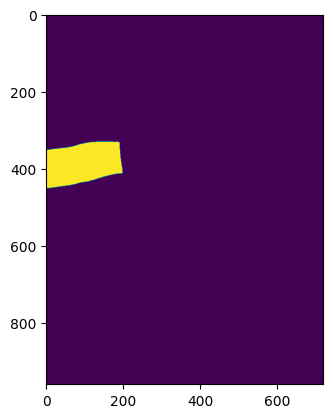

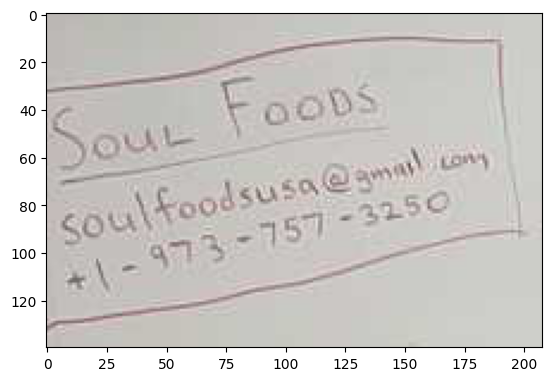

torch.Size([512])


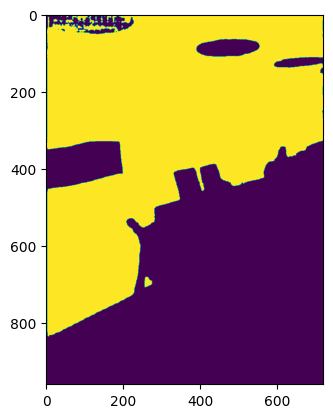

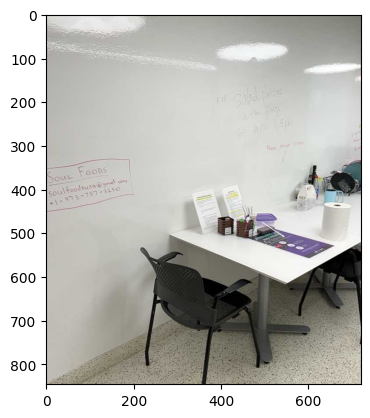

torch.Size([512])


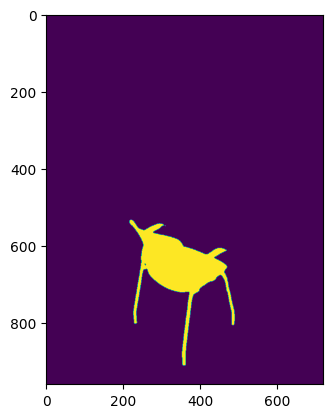

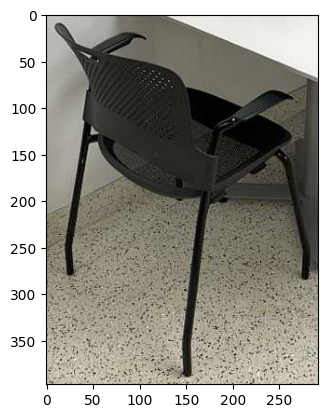

torch.Size([512])


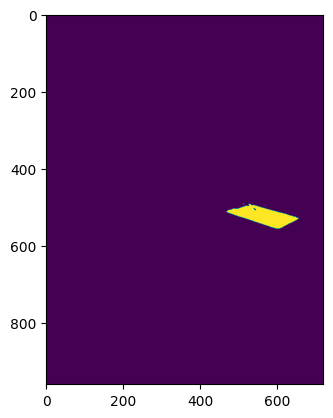

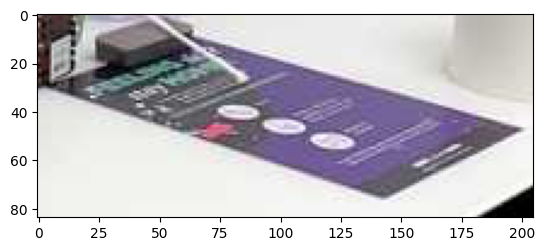

torch.Size([512])


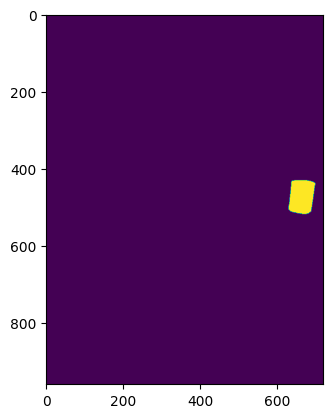

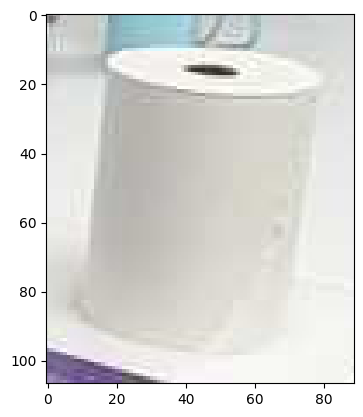

torch.Size([512])


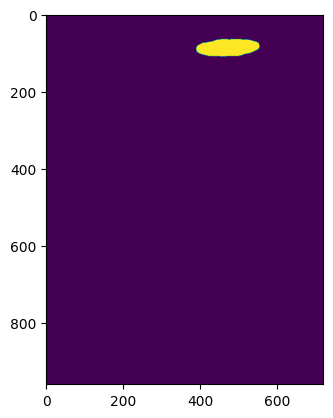

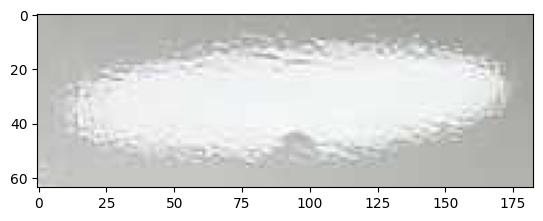

torch.Size([512])


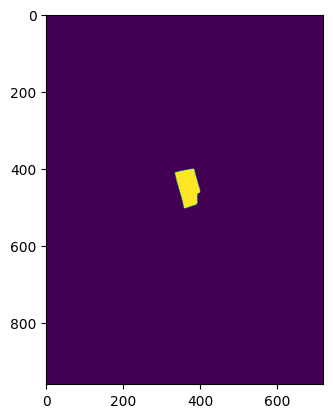

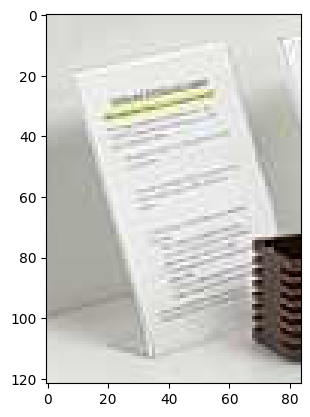

torch.Size([512])


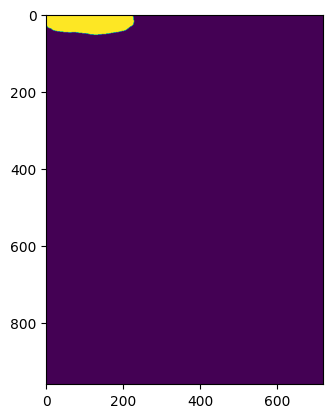

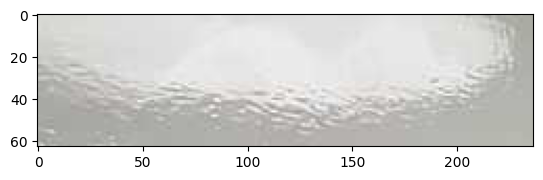

torch.Size([512])


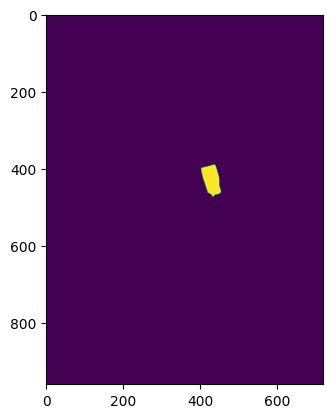

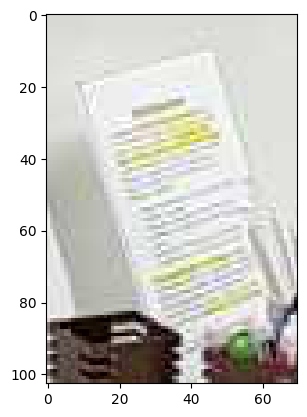

torch.Size([512])


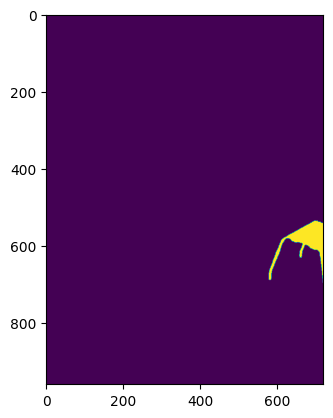

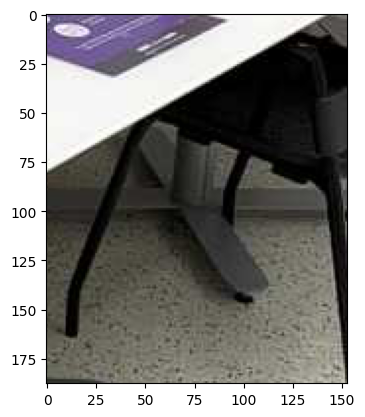

torch.Size([512])


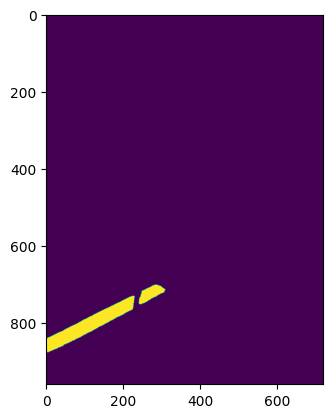

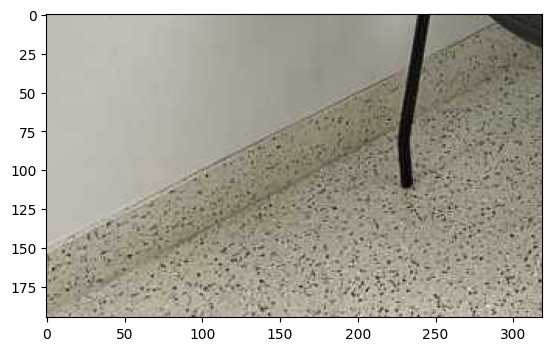

torch.Size([512])


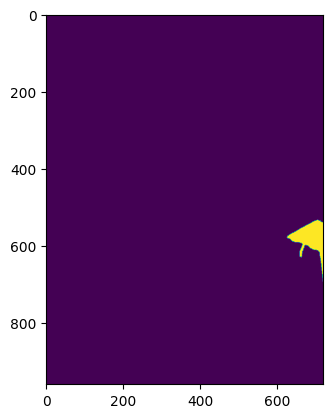

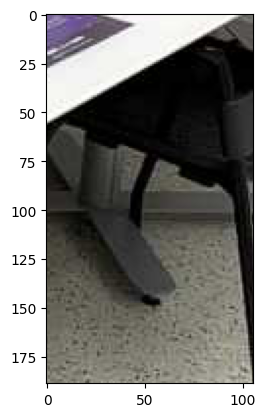

torch.Size([512])


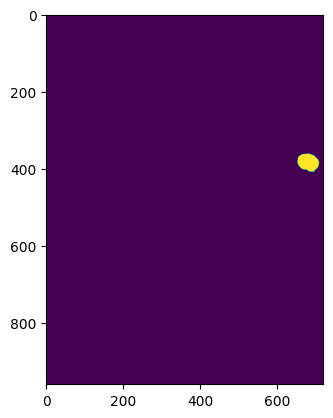

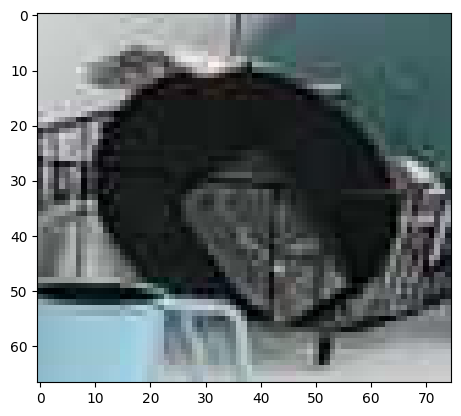

torch.Size([512])


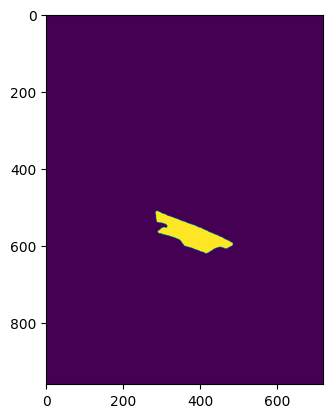

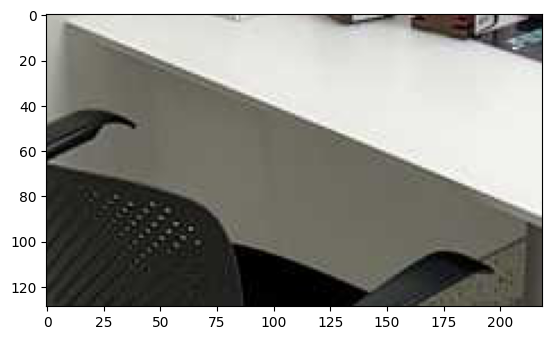

torch.Size([512])


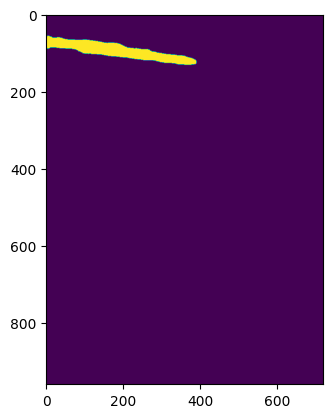

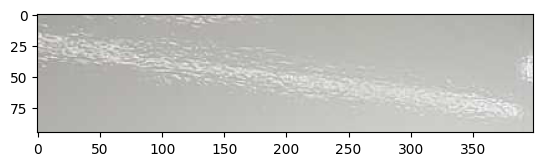

torch.Size([512])


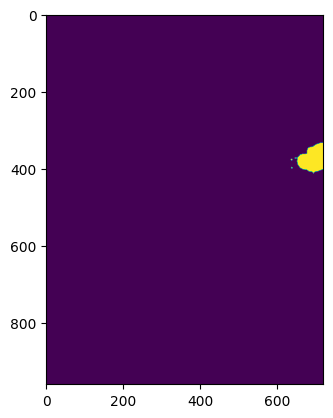

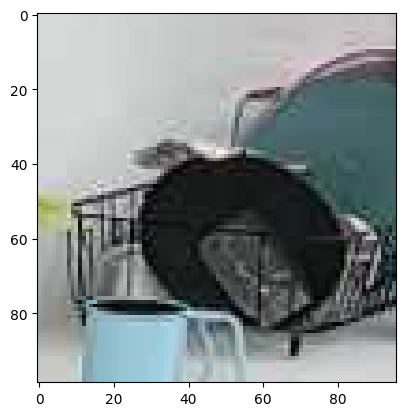

torch.Size([512])
17 17


In [19]:
masks = mask_generator.generate(image.permute(1, 2, 0).numpy())
idx = 0
new_masks = []
for mask in masks:
    if mask['bbox'][2] > 32 and  mask['bbox'][3] > 32:
        new_masks.append(mask)
        idx += 1
        crop_image = image[:, max(0, mask['bbox'][1] - 10) : min(mask['bbox'][1] + mask['bbox'][3] + 10, image_height), 
                         max(0, mask['bbox'][0] - 10) : min(mask['bbox'][0] + mask['bbox'][2] + 10, image_width)]
        #seg_image = torch.clone(image)
        #seg_image[:, ~mask['segmentation']] = 0
        #seg_image = seg_image[:, max(0, mask['bbox'][1] - 10) : min(mask['bbox'][1] + mask['bbox'][3] + 10, image_height), 
        #                 max(0, mask['bbox'][0] - 10) : min(mask['bbox'][0] + mask['bbox'][2] + 10, image_width)]
        plt.imshow(mask['segmentation'])
        plt.show()
        plt.imshow(crop_image.permute(1, 2, 0))
        plt.show()
        image[:, mask['segmentation']]
        #plt.imshow(seg_image.permute(1, 2, 0))
        #plt.show()
        feature = clip_model.encode_image(resize(crop_image.unsqueeze(0)).cuda()).squeeze(0).cpu().float()
        #label = torch.argmax((feature / torch.linalg.norm(feature)) @ embeddings)
        print(feature.shape)
        #print(label)
print(idx, len(masks))
masks = new_masks

In [15]:
from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb
embeddings = get_clip_embeddings(dataset._all_classes)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│   5 │   texts = [prompt + x for x in vocabulary]                                                 │
│   6 │   emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()                      │
│   7 │   return emb                                                                               │
│ ❱ 8 embeddings = get_clip_embeddings(dataset._all_classes)                                       │
│   9                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'R3DSemanticDataset' object has no attribute '_all_classes'

In [40]:
#torch.save(embeddings, "text")
embeddings = torch.load("text")
embeddings = (embeddings / torch.linalg.norm(embeddings, dim = 0)).cpu()

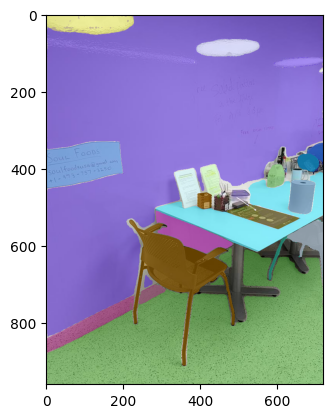

In [53]:
import cv2
import supervision as sv
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.permute(1, 2, 0).numpy().copy(), detections=detections)
plt.imshow(annotated_image)

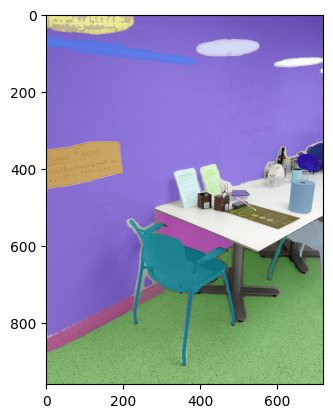

In [20]:
import supervision as sv
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=masks)
annotated_image = mask_annotator.annotate(scene=image.permute(1, 2, 0).numpy().copy(), detections=detections)
plt.imshow(annotated_image)

In [55]:
detections.class_id = torch.randint(0, 200, (len(masks),))

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

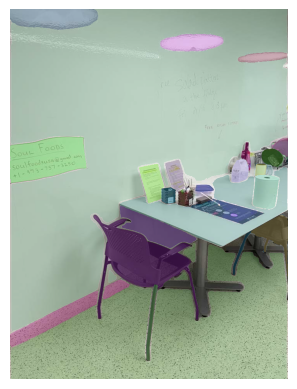

In [12]:
import numpy as np
plt.imshow(image.permute(1, 2, 0))
show_anns(masks)
plt.axis('off')
plt.show() 

In [3]:
labelled_dataset = DeticDenseLabelledDataset(
    dataset, 
    use_extra_classes=False, 
    exclude_gt_images=False, 
    use_lseg=False, 
    subsample_prob=0.01, 
    visualize_results=True, 
    detic_threshold=0.4,
    visualization_path="detic_labelled_results",
)

INFO - 2023-07-10 17:08:59,595 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO - 2023-07-10 17:09:00,710 - SentenceTransformer - Use pytorch device: cuda
INFO - 2023-07-10 17:09:03,858 - file_io - URL https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth cached in /home/robot-lab/.torch/iopath_cache/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth
INFO - 2023-07-10 17:09:03,859 - checkpoint - [Checkpointer] Loading from /home/robot-lab/.torch/iopath_cache/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...


Loading pretrained CLIP


Calculating Detic features:   0%|                                                               | 0/757 [00:00<?, ?it/s]/home/robot-lab/anaconda3/envs/cf/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627336325426/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return default_collate([torch.as_tensor(b) for b in batch])
Calculating Detic features: 100%|█████████████████████████████████████████████████████| 757/757 [05:31<00:00,  2.28it/s]


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

## Visualizing the labelling

We can visualize the labelling with our web-image models by setting the `visualize_results=True` and `visualization_path` to a desired path, as seen in the above cell. This step is incredibly useful for debugging, and can help you understand what the model is doing. We have found that the downstream training can sometimes be suboptimal if the initial labelling is not that great. In this case, we can use the visualization to understand what the model is doing, and then if necessary, modify the set of to be more accurate.

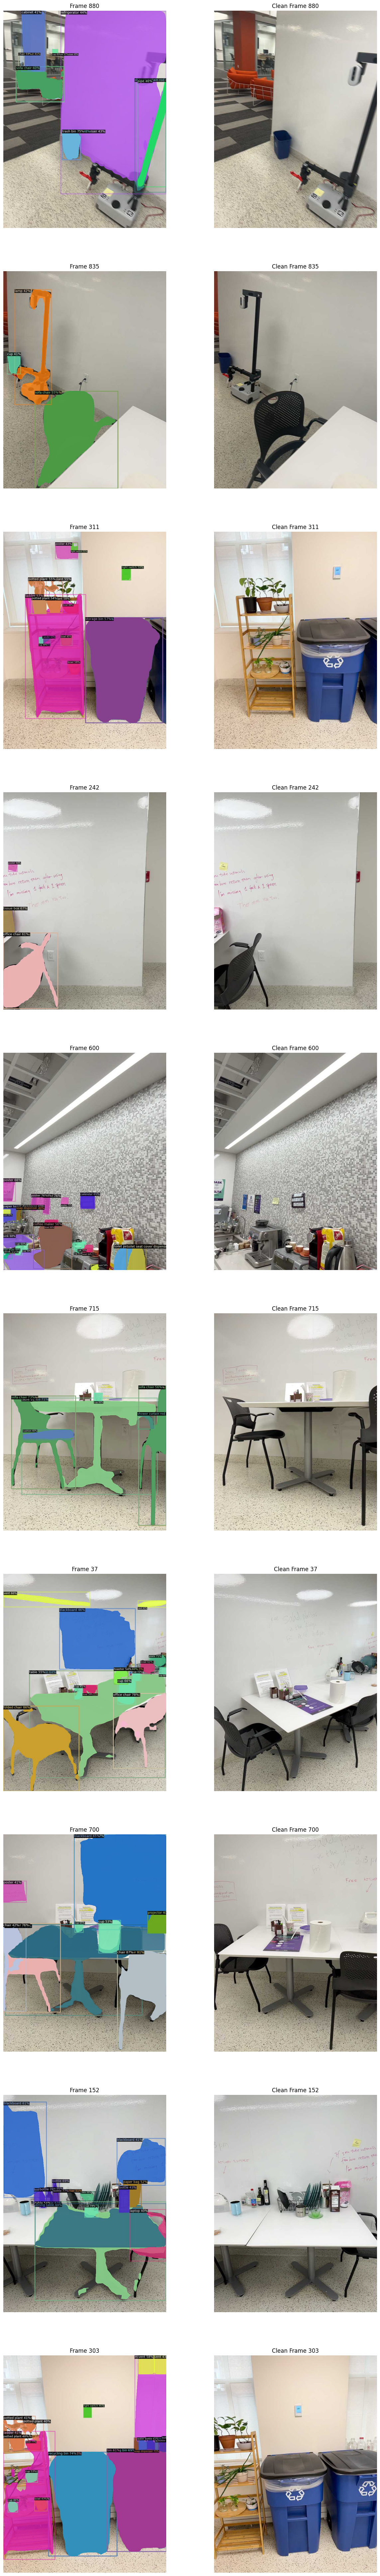

In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

NUM_IMAGES = 10
TOTAL_FRAMES = glob.glob("detic_labelled_results/*.jpg")
fig, axes = plt.subplots(NUM_IMAGES, 2, figsize=(15, 10 * NUM_IMAGES))

for idx in range(NUM_IMAGES):
    random_index = np.random.randint(0, len(TOTAL_FRAMES) / 2)
    axes[idx][0].imshow(Image.open(f"detic_labelled_results/{random_index}.jpg"))
    axes[idx][0].axis("off")
    axes[idx][0].set_title(f"Frame {random_index}")
    axes[idx][1].imshow(Image.open(f"detic_labelled_results/Clean_{random_index}.jpg"))
    axes[idx][1].axis("off")
    axes[idx][1].set_title(f"Clean Frame {random_index}")

## Save the dataloader

Finally, we save the dataloader so that we can use it on our next step for training.

In [5]:
torch.save(labelled_dataset, "../sam_labeled_dataset.pt")

In [1]:
torch.save(labelled_dataset, "../detic_labeled_dataset.pt")

NameError: name 'torch' is not defined